# 1. Setup

In [1]:
# Standard library
from pathlib import Path

# Third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tomllib
from rich import print
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import pearsonr, spearmanr

In [2]:
# Load configuration
with open('config.toml', 'rb') as f:
    config = tomllib.load(f)

print(f'✅ Configuration loaded with {len(config)} keys')

✅ Configuration loaded with 6 keys

In [3]:
# Load dataset
notebook_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
dataset_path = notebook_dir / 'datasets' / 'dataset_raw.csv'

if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {dataset_path}")

print(f"📁 Loading dataset from: {dataset_path}")
df = pd.read_csv(dataset_path, delimiter=';')

print(f"✅ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
df.head()

📁 Loading dataset from: c:\Users\Craig\Documents\Python\msc_ai_module_final\datasets\dataset_raw.csv

✅ Dataset loaded: 4,424 rows × 37 columns

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [4]:
# Normalise column names to snake_case
def normalise_columns(df):
    def snake_case(text):
        text = '_'.join(' '.join(str(text).split()).lower().split())
        text = text.replace('/', '_')
        text = text.replace('(', '')
        text = text.replace(')', '')
        text = text.replace('\'', '')
        return text
    
    df = df.copy()
    df.columns = [snake_case(col) for col in df.columns]
    return df

df = normalise_columns(df)
print('✅ Column names normalised to snake_case')

✅ Column names normalised to snake_case

In [5]:
# Cast categorical columns to proper dtype using config
categorical_cols = config.get('dataset_features', {}).get('categorical_features', [])

# Check which categorical features are present
present_categorical = [col for col in categorical_cols if col in df.columns]
missing_categorical = [col for col in categorical_cols if col not in df.columns]

# Cast present categorical columns to category dtype
for col in present_categorical:
    df[col] = df[col].astype('category')

print(f'✅ {len(present_categorical)} categorical columns cast to category dtype')

if missing_categorical:
    print(f'⚠️  {len(missing_categorical)} categorical features missing from dataset: {missing_categorical}')

✅ 18 categorical columns cast to category dtype

In [6]:
# Create binary target variable for dropout prediction
df['target_binary'] = df['target'].map({'Dropout': 1, 'Graduate': 0, 'Enrolled': 0})

print("✅ Binary target variable created (1=Withdrawal, 0=Continue)")

✅ Binary target variable created (1=Withdrawal, 0=Continue)

In [7]:
# Remove Second Semester Features (Data Leakage Prevention)
df_with_sem2 = df.copy()
SECOND_SEM_COLS = [col for col in df.columns if '2nd_sem' in col]

print(f"Second semester features to remove: {len(SECOND_SEM_COLS)} columns")
print(f"Features: {SECOND_SEM_COLS}")

# Remove them from dataset
df.drop(columns=SECOND_SEM_COLS, inplace=True)
print("✅ Second semester features removed to prevent data leakage")

# Store removed columns for later reference
REMOVED_FEATURES = SECOND_SEM_COLS.copy()
print(f"📝 Stored {len(REMOVED_FEATURES)} removed feature names")

Second semester features to remove: 6 columns

Features: ['curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 
'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 
'curricular_units_2nd_sem_without_evaluations']

✅ Second semester features removed to prevent data leakage

📝 Stored 6 removed feature names

# 2. Dataset Overview

In [8]:
# Check for missing values
missing_summary = df.isnull().sum()
total_missing = missing_summary.sum()

print(f"Total missing values: {total_missing:,}")
print(f"Columns with missing values: {(missing_summary > 0).sum()}")

if total_missing > 0:
    print("\nMissing values by column:")
    print(missing_summary[missing_summary > 0].sort_values(ascending=False))
else:
    print("✅ No missing values found")

# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates:,}")

if duplicates > 0:
    print("⚠️  Found duplicate rows - investigate further")
else:
    print("✅ No duplicate rows found")

# Basic shape confirmation
print(f"\nDataset shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

Total missing values: 0

Columns with missing values: 0

✅ No missing values found

Duplicate rows: 0

✅ No duplicate rows found

Dataset shape: 4,424 rows × 32 columns

In [9]:
# Display dataset information
print("Dataset Information:")
df.info()

print(f"\n✅ Features in dataset: {len(df.columns) - 1}")  # Exclude target columns
print("Target distribution:")
print(df['target'].value_counts(normalize=True))

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   marital_status                                4424 non-null   category
 1   application_mode                              4424 non-null   category
 2   application_order                             4424 non-null   category
 3   course                                        4424 non-null   category
 4   daytime_evening_attendance                    4424 non-null   category
 5   previous_qualification                        4424 non-null   category
 6   previous_qualification_grade                  4424 non-null   float64 
 7   nacionality                                   4424 non-null   category
 8   mothers_qualification                         4424 non-null   category
 9   fathers_qualification                         4424 n

✅ Features in dataset: 31

Target distribution:

target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

# 3. Feature Definition

In [10]:
# Get feature lists from config
config_continuous = config.get('dataset_features', {}).get('continuous_features', [])
config_categorical = config.get('dataset_features', {}).get('categorical_features', [])

print(f'📋 Config expects: {len(config_continuous)} continuous, {len(config_categorical)} categorical features')

# Check for missing features before filtering
missing_continuous = [f for f in config_continuous if f not in df.columns and f not in REMOVED_FEATURES]
missing_categorical = [f for f in config_categorical if f not in df.columns and f not in REMOVED_FEATURES]

if missing_continuous:
    print(f'⚠️  Missing continuous features: {missing_continuous}')
if missing_categorical:
    print(f'⚠️  Missing categorical features: {missing_categorical}')

# Remove any features that were already dropped from dataset
continuous_features = [f for f in config_continuous if f not in REMOVED_FEATURES]
categorical_features = [f for f in config_categorical if f not in REMOVED_FEATURES]

# Filter to only include features present in dataset
continuous_features = [f for f in continuous_features if f in df.columns]
categorical_features = [f for f in categorical_features if f in df.columns]

# Verify feature classification matches actual dtypes after casting
actual_categorical = df.select_dtypes(include=['category']).columns.tolist()
actual_continuous = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target columns from counts
if 'target' in actual_categorical:
    actual_categorical.remove('target')
if 'target_binary' in actual_continuous:
    actual_continuous.remove('target_binary')

print(f'✅ Final counts: {len(continuous_features)} continuous, {len(categorical_features)} categorical')
print(f'✅ Actual dtypes: {len(actual_continuous)} continuous, {len(actual_categorical)} categorical')

# Detailed mismatch analysis
config_cat_set = set(categorical_features)
actual_cat_set = set(actual_categorical)
if config_cat_set != actual_cat_set:
    print(f'⚠️  Categorical feature dtype mismatch detected')
    if config_cat_set - actual_cat_set:
        print(f'   Expected categorical but not cast: {list(config_cat_set - actual_cat_set)}')
    if actual_cat_set - config_cat_set:
        print(f'   Cast to categorical but not in config: {list(actual_cat_set - config_cat_set)}')

📋 Config expects: 18 continuous, 18 categorical features

✅ Final counts: 12 continuous, 18 categorical

✅ Actual dtypes: 12 continuous, 18 categorical

# 4. Target Distribution

In [11]:
# Display target distribution
print("Target Distribution:")
target_counts = df['target'].value_counts()
target_props = df['target'].value_counts(normalize=True)

for outcome in target_counts.index:
    count = target_counts[outcome]
    prop = target_props[outcome]
    print(f"  {outcome}: {count:,} ({prop:.1%})")

print(f"\nBinary Target Distribution:")
binary_counts = df['target_binary'].value_counts()
binary_props = df['target_binary'].value_counts(normalize=True)

for value in binary_counts.index:
    count = binary_counts[value]
    prop = binary_props[value]
    label = "Withdrawal" if value == 1 else "Continue"
    print(f"  {label} ({value}): {count:,} ({prop:.1%})")

Target Distribution:

Graduate: 2,209 (49.9%)

Dropout: 1,421 (32.1%)

Enrolled: 794 (17.9%)

Binary Target Distribution:

Continue (0): 3,003 (67.9%)

Withdrawal (1): 1,421 (32.1%)

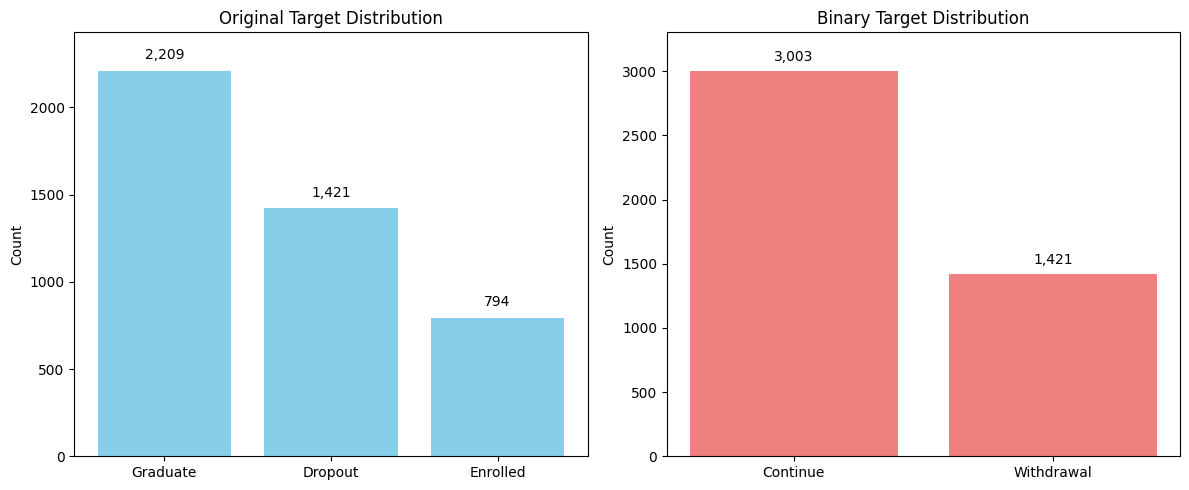

In [12]:
# Create target distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original target distribution
target_counts = df['target'].value_counts()
axes[0].bar(target_counts.index, target_counts.values, color='skyblue')
axes[0].set_title('Original Target Distribution')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(target_counts.values) * 1.1)  # 10% bigger than max
for i, (label, count) in enumerate(target_counts.items()):
    axes[0].text(i, count + 50, f'{count:,}', ha='center', va='bottom')

# Binary target distribution
binary_counts = df['target_binary'].value_counts()
binary_labels = ['Continue', 'Withdrawal']
max_binary = max(binary_counts[0], binary_counts[1])
axes[1].bar(binary_labels, [binary_counts[0], binary_counts[1]], color='lightcoral')
axes[1].set_title('Binary Target Distribution')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, max_binary * 1.1)  # 10% bigger than max
for i, count in enumerate([binary_counts[0], binary_counts[1]]):
    axes[1].text(i, count + 50, f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 5. Continuous Features Analysis

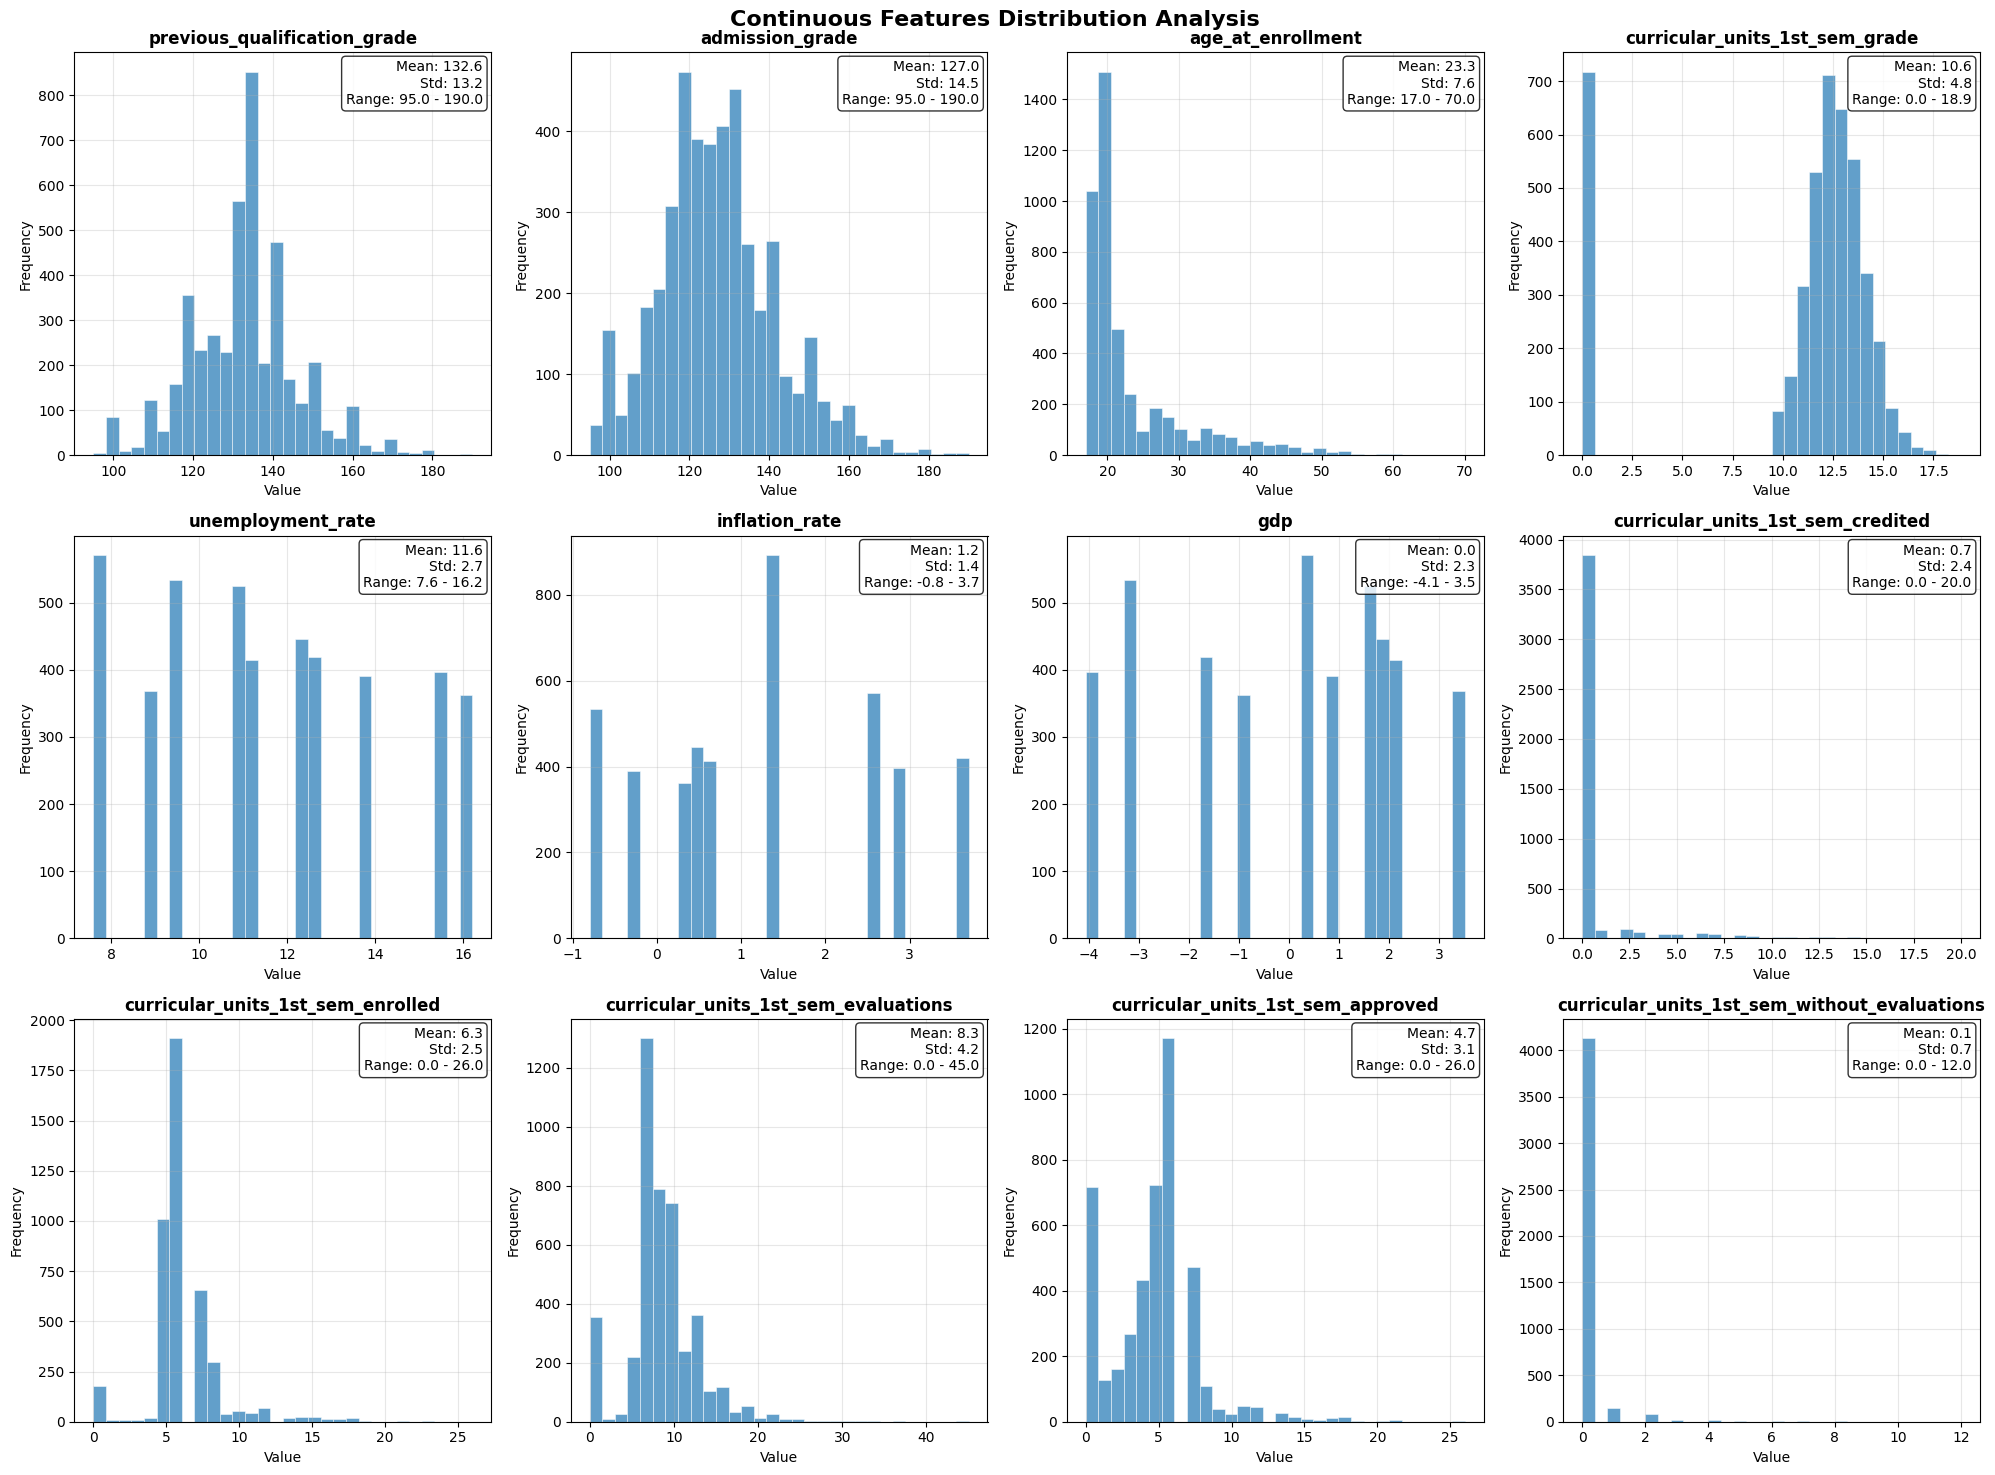

In [13]:
# Plot continuous features distributions
def plot_continuous_features_distribution(df, continuous_features):
    n_features = len(continuous_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    fig.suptitle('Continuous Features Distribution Analysis', fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, feature in enumerate(continuous_features):
        ax = axes[i]
        data = df[feature]
        
        # Create histogram
        ax.hist(data, bins=30, alpha=0.7, edgecolor='white', linewidth=0.5)
        
        # Add statistics
        stats_text = f'Mean: {data.mean():.1f}\nStd: {data.std():.1f}\nRange: {data.min():.1f} - {data.max():.1f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(feature, fontsize=12, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for j in range(len(continuous_features), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_continuous_features_distribution(df, continuous_features)

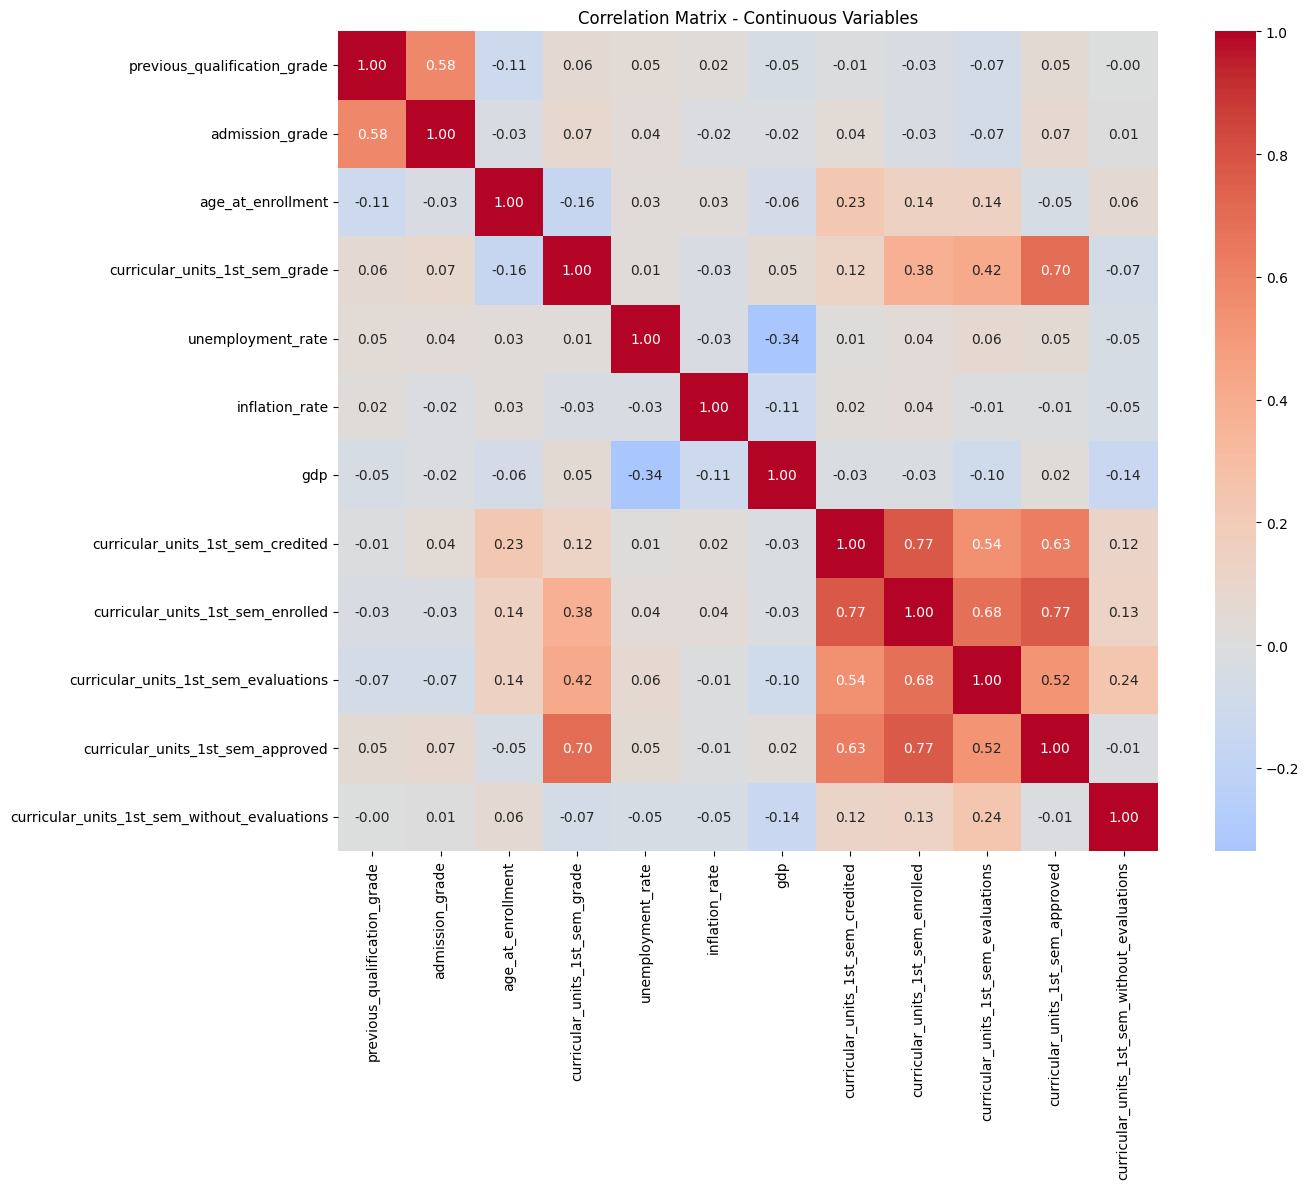

Highly correlated pairs (>0.8):

No pairs with correlation > 0.8 found

In [14]:
# Create correlation heatmap for continuous features
def plot_correlation_heatmap(df, continuous_features):
    correlation_matrix = df[continuous_features].corr()
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, 
                annot=True,
                cmap='coolwarm',
                center=0,
                square=True,
                fmt='.2f')
    
    plt.title('Correlation Matrix - Continuous Variables')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

correlation_matrix = plot_correlation_heatmap(df, continuous_features)

# Find high correlations (>0.8)
print("Highly correlated pairs (>0.8):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_value))
            print(f"  {col1} and {col2}: {corr_value:.2f}")

if not high_corr_pairs:
    print("  No pairs with correlation > 0.8 found")

In [15]:
# Check Variance Inflation Factor (VIF) for multicollinearity
def check_vif(df, continuous_features):
    vif_data = add_constant(df[continuous_features].dropna())
    
    vif_results = []
    for i, col in enumerate(vif_data.columns[1:], 1):  # Skip constant column
        vif = variance_inflation_factor(vif_data.values, i)
        vif_results.append({'Feature': col, 'VIF': round(vif, 2)})
    
    vif_df = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)
    
    def interpret_vif(vif_score):
        if vif_score < 2:
            return "Low (No concern)"
        elif vif_score < 5:
            return "Moderate (Monitor)"
        elif vif_score < 10:
            return "High (Consider removal)"
        else:
            return "Very High (Remove)"
    
    vif_df['Interpretation'] = vif_df['VIF'].apply(interpret_vif)
    
    print("VIF Analysis:")
    print("< 2: No multicollinearity concern")
    print("2-5: Moderate correlation, monitor")
    print("5-10: High correlation, consider removal")
    print("> 10: Very high correlation, strong removal candidate\n")
    
    return vif_df

vif_results = check_vif(df, continuous_features)
print("VIF Results:")
print(vif_results)

# Identify features requiring removal
high_vif_features = vif_results[vif_results['VIF'] > 5]['Feature'].tolist()
if high_vif_features:
    print(f'\n⚠️  HIGH VIF FEATURES REQUIRING REMOVAL:')
    for feature in high_vif_features:
        vif_score = vif_results[vif_results['Feature'] == feature]['VIF'].iloc[0]
        print(f'   • {feature}: VIF = {vif_score}')
    print('   Recommend removing highest VIF features iteratively')
    
    # CRITICAL: Address the multicollinearity issue
    print(f'\n🔧 MULTICOLLINEARITY ACTION REQUIRED:')
    print(f'   The feature "{high_vif_features[0]}" has high multicollinearity (VIF > 5)')
    print(f'   This violates assumptions for linear models and inflates standard errors')
    print(f'   MUST either:')
    print(f'   1. Remove this feature before modeling')
    print(f'   2. Apply dimensionality reduction (PCA)')
    print(f'   3. Use regularization (Ridge/Lasso)')
    print(f'   4. Justify why multicollinearity is acceptable for this analysis')
else:
    print('\n✅ No high VIF features detected - multicollinearity acceptable')

VIF Analysis:

< 2: No multicollinearity concern

2-5: Moderate correlation, monitor

5-10: High correlation, consider removal

> 10: Very high correlation, strong removal candidate

VIF Results:

Feature   VIF  \
10             curricular_units_1st_sem_approved  6.38   
8              curricular_units_1st_sem_enrolled  4.83   
7              curricular_units_1st_sem_credited  3.63   
3                 curricular_units_1st_sem_grade  3.44   
9           curricular_units_1st_sem_evaluations  2.40   
1                                admission_grade  1.56   
0                   previous_qualification_grade  1.54   
6                                            gdp  1.20   
2                              age_at_enrollment  1.17   
4                              unemployment_rate  1.16   
11  curricular_units_1st_sem_without_evaluations  1.15   
5                                 inflation_rate  1.03   

             Interpretation  
10  High (Consider removal)  
8        Moderate (Monitor)  
7        Moderate (Monitor)  
3        Moderate (Monitor)  
9        Moderate (Monitor)  
1          Low (No concern)  
0          Low (No concern)  
6          Low (No concern)  
2          Low (No concern)  
4          Low (No concern)  
11         Low (No concern)  
5          Low (No concern)

⚠️  HIGH VIF FEATURES REQUIRING REMOVAL:

• curricular_units_1st_sem_approved: VIF = 6.38

Recommend removing highest VIF features iteratively

🔧 MULTICOLLINEARITY ACTION REQUIRED:

The feature "curricular_units_1st_sem_approved" has high multicollinearity (VIF > 5)

This violates assumptions for linear models and inflates standard errors

MUST either:

1. Remove this feature before modeling

2. Apply dimensionality reduction (PCA)

3. Use regularization (Ridge/Lasso)

4. Justify why multicollinearity is acceptable for this analysis

📊 Continuous Features vs Withdrawal Risk:

Feature  Correlation P_Value Significant
              curricular_units_1st_sem_grade       -0.481  <0.001         Yes
           curricular_units_1st_sem_approved       -0.479  <0.001         Yes
                           age_at_enrollment        0.254  <0.001         Yes
           curricular_units_1st_sem_enrolled       -0.125  <0.001         Yes
                             admission_grade       -0.096  <0.001         Yes
        curricular_units_1st_sem_evaluations       -0.090  <0.001         Yes
                previous_qualification_grade       -0.078  <0.001         Yes
curricular_units_1st_sem_without_evaluations        0.054  <0.001         Yes
                                         gdp       -0.046   0.002         Yes
           curricular_units_1st_sem_credited       -0.029   0.051          No
                              inflation_rate        0.028   0.064          No
                           unemployment_rate        0.013   0.388          No

✅ 9/12 features significantly correlated with withdrawal

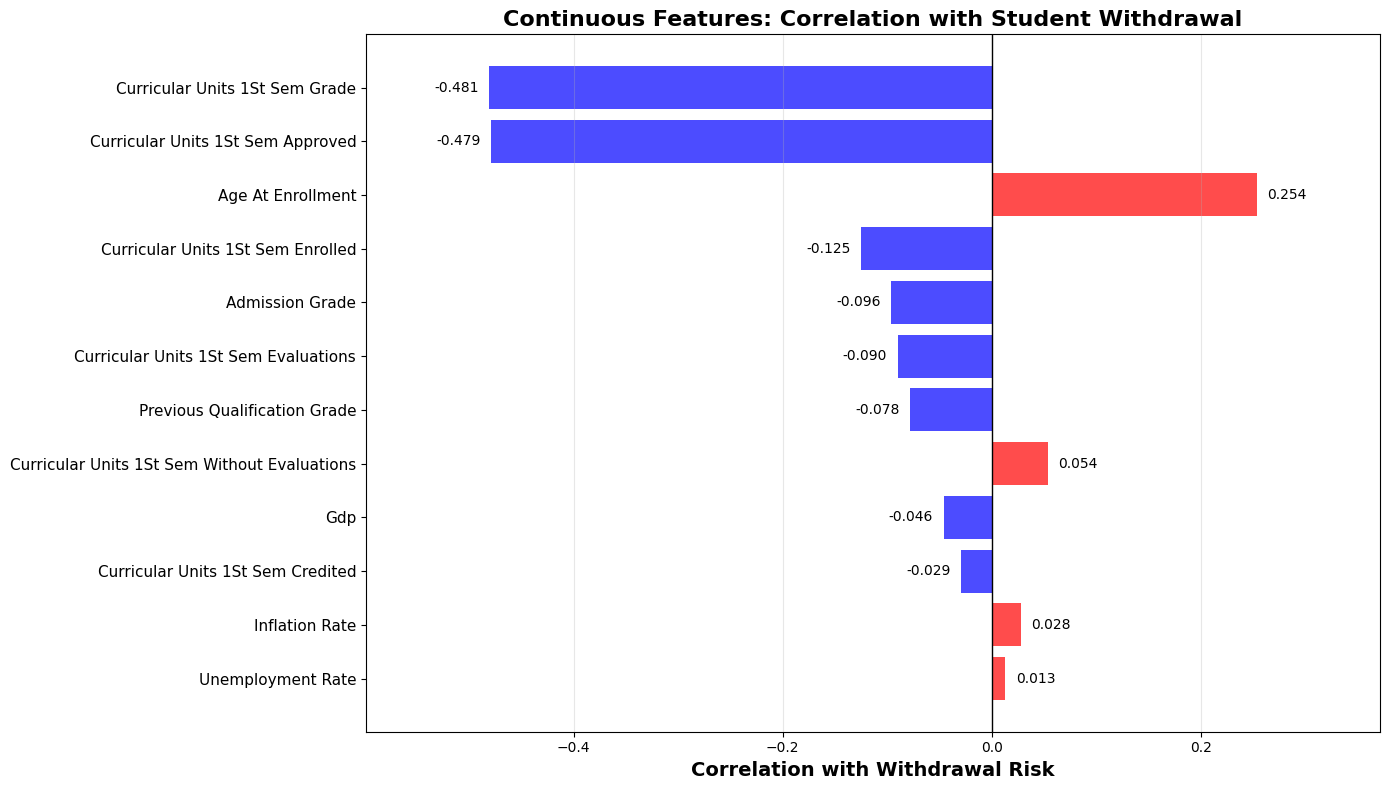

🎯 Strongest predictor: curricular_units_1st_sem_grade (r = -0.481)

In [16]:
############ JUPYTER NOTEBOOK CELL DIVIDER ############
# %% code [30]
# Continuous Features vs Target Correlation Analysis
from scipy.stats import pearsonr

def analyse_continuous_target_correlation(df, continuous_features, target_col):
    """Calculate correlation between continuous features and binary target"""
    results = []
    
    for feature in continuous_features:
        corr, p_value = pearsonr(df[feature], df[target_col])
        results.append({
            'Feature': feature,
            'Correlation': round(corr, 3),
            'P_Value': f'{p_value:.3f}' if p_value >= 0.001 else '<0.001',
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    
    return pd.DataFrame(results).sort_values('Correlation', key=abs, ascending=False)

# Calculate correlations
corr_results = analyse_continuous_target_correlation(df, continuous_features, 'target_binary')

print('📊 Continuous Features vs Withdrawal Risk:')
print(corr_results.to_string(index=False))

# Quick summary
significant = corr_results[corr_results['Significant'] == 'Yes']
print(f'\n✅ {len(significant)}/{len(continuous_features)} features significantly correlated with withdrawal')

############ JUPYTER NOTEBOOK CELL DIVIDER ############
# %% code [31]
# Visualisation: Correlation with Target
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Correlation bar chart
plot_data = corr_results.sort_values('Correlation', key=abs, ascending=True)
colours = ['red' if x > 0 else 'blue' for x in plot_data['Correlation']]
bars = ax.barh(range(len(plot_data)), plot_data['Correlation'], color=colours, alpha=0.7)

ax.set_yticks(range(len(plot_data)))
ax.set_yticklabels([name.replace('_', ' ').title() for name in plot_data['Feature']], fontsize=11)
ax.set_xlabel('Correlation with Withdrawal Risk', fontsize=14, fontweight='bold')
ax.set_title('Continuous Features: Correlation with Student Withdrawal', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0, color='black', linewidth=1)

# Add correlation values on bars
for bar, corr in zip(bars, plot_data['Correlation']):
    ax.text(corr + (0.01 if corr > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
            f'{corr:.3f}', ha='left' if corr > 0 else 'right', va='center', fontsize=10)

# Extend X-axis by 10% in both directions to prevent label cutoff
x_min, x_max = ax.get_xlim()
x_range = x_max - x_min
ax.set_xlim(x_min - 0.1 * x_range, x_max + 0.1 * x_range)

plt.tight_layout()
plt.show()

print(f'🎯 Strongest predictor: {corr_results.iloc[0]["Feature"]} (r = {corr_results.iloc[0]["Correlation"]})')

# 6. Categorical Features Analysis

In [17]:
# Check cardinality of categorical features
def check_cardinality(df, cols):
    cardinality_data = []
    for col in cols:
        cardinality_data.append({
            'Feature': col,
            'Cardinality': df[col].nunique()
        })
    return pd.DataFrame(cardinality_data).sort_values('Cardinality')

cardinality_df = check_cardinality(df, categorical_features)
print('Categorical Feature Cardinality:')
print(cardinality_df)

# Check for severely imbalanced features (>95% in one category)
def check_class_imbalance(df, cols, threshold=0.95):
    imbalanced_features = []
    for col in cols:
        max_proportion = df[col].value_counts(normalize=True).max()
        if max_proportion > threshold:
            imbalanced_features.append({
                'Feature': col,
                'Max_Proportion': f'{max_proportion:.2%}',
                'Dominant_Category': df[col].value_counts().index[0]
            })
    return pd.DataFrame(imbalanced_features)

imbalanced = check_class_imbalance(df, categorical_features)
print(f'\nSeverely Imbalanced Features (>{95}% in one category):')
if len(imbalanced) > 0:
    print(imbalanced)
else:
    print('None found')


Categorical Feature Cardinality:

Feature  Cardinality
4   daytime_evening_attendance            2
13                      debtor            2
14     tuition_fees_up_to_date            2
15                      gender            2
12   educational_special_needs            2
11                   displaced            2
17               international            2
16          scholarship_holder            2
0               marital_status            6
2            application_order            8
3                       course           17
5       previous_qualification           17
1             application_mode           18
6                  nacionality           21
7        mothers_qualification           29
9           mothers_occupation           32
8        fathers_qualification           34
10          fathers_occupation           46

Severely Imbalanced Features (>95% in one category):

Feature Max_Proportion  Dominant_Category
0                nacionality         97.51%                  1
1  educational_special_needs         98.85%                  0
2              international         97.51%                  0

In [18]:
# Use previously defined functions (avoiding duplication)
print("Categorical Feature Cardinality:")
print(cardinality_df)

print(f"\nSeverely Imbalanced Features (>{95}% in one category):")
if len(imbalanced) > 0:
    print(imbalanced)
else:
    print("None found")

Categorical Feature Cardinality:

Feature  Cardinality
4   daytime_evening_attendance            2
13                      debtor            2
14     tuition_fees_up_to_date            2
15                      gender            2
12   educational_special_needs            2
11                   displaced            2
17               international            2
16          scholarship_holder            2
0               marital_status            6
2            application_order            8
3                       course           17
5       previous_qualification           17
1             application_mode           18
6                  nacionality           21
7        mothers_qualification           29
9           mothers_occupation           32
8        fathers_qualification           34
10          fathers_occupation           46

Severely Imbalanced Features (>95% in one category):

Feature Max_Proportion  Dominant_Category
0                nacionality         97.51%                  1
1  educational_special_needs         98.85%                  0
2              international         97.51%                  0

In [19]:
# Test statistical association between categorical features and target
def chi_square_test(df, categorical_features, target_col):
    results = []
    
    for col in categorical_features:
        contingency_table = pd.crosstab(df[col], df[target_col])
        chi2, p_value, _, expected = chi2_contingency(contingency_table)
        
        # Check chi-square test assumptions
        min_expected = expected.min()
        cells_below_5 = (expected < 5).sum()
        total_cells = expected.size
        percent_below_5 = (cells_below_5 / total_cells) * 100
        
        # Chi-square is reliable if <20% of cells have expected frequency <5
        reliable = percent_below_5 < 20
        
        results.append({
            'Feature': col,
            'Chi2_Score': round(chi2, 2),
            'P_Value': f'{p_value:.2e}' if p_value < 0.001 else f'{p_value:.6f}',
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Min_Expected': round(min_expected, 2),
            'Cells_Below_5': f'{cells_below_5}/{total_cells}',
            'Reliable': 'Yes' if reliable else 'No'
        })
    
    return pd.DataFrame(results).sort_values('Chi2_Score', ascending=False)

chi2_results = chi_square_test(df, categorical_features, 'target_binary')
print('Chi-Square Test Results (association with withdrawal):')
print('Note: Test is reliable when <20% of cells have expected frequency <5')
print(chi2_results)

# Show unreliable results
unreliable = chi2_results[chi2_results['Reliable'] == 'No']
if len(unreliable) > 0:
    print(f'\n⚠️  {len(unreliable)} features have unreliable chi-square results:')
    for _, row in unreliable.iterrows():
        print(f'   • {row["Feature"]}: {row["Cells_Below_5"]} cells with expected freq <5')
    
    print(f'\n🚨 STATISTICAL VALIDITY CONCERN:')
    print(f'   Chi-square tests for {len(unreliable)} features violate assumptions')
    print(f'   Conclusions about statistical significance may be invalid')
    print(f'   RECOMMENDATIONS:')
    print(f'   1. Use Fisher\'s exact test for features with small expected frequencies')
    print(f'   2. Group rare categories to meet chi-square assumptions')
    print(f'   3. Use non-parametric alternatives (e.g., mutual information)')
    print(f'   4. Acknowledge limitations in interpretation')
    print(f'   Note: Only trust "Significant" results where Reliable="Yes"')
else:
    print('\n✅ All chi-square tests meet statistical assumptions')

Chi-Square Test Results (association with withdrawal):

Note: Test is reliable when <20% of cells have expected frequency <5

Feature  Chi2_Score    P_Value Significant  \
14     tuition_fees_up_to_date      811.93  1.37e-178         Yes   
1             application_mode      399.12   2.84e-74         Yes   
3                       course      298.27   5.83e-54         Yes   
16          scholarship_holder      265.10   1.32e-59         Yes   
13                      debtor      231.28   3.13e-52         Yes   
9           mothers_occupation      203.37   3.05e-27         Yes   
5       previous_qualification      202.62   2.34e-34         Yes   
7        mothers_qualification      186.09   2.85e-25         Yes   
15                      gender      183.16   9.88e-42         Yes   
8        fathers_qualification      181.59   1.92e-22         Yes   
10          fathers_occupation      167.72   4.85e-16         Yes   
0               marital_status       59.45   1.58e-11         Yes   
11                   displaced       50.41   1.25e-12         Yes   
2            application_order       39.40   1.64e-06         Yes   
4   daytime_evening_attendance       28.12   1.14e-07         Yes   
6                  nacionality       17.67   0.609335          No   
17               international        0.34   0.558102          No   
12   educational_special_needs        0.00   0.971446          No   

    Min_Expected Cells_Below_5 Reliable  
14        169.59           0/4      Yes  
1           0.32          9/36       No  
3           3.85          1/34      Yes  
16        353.00           0/4      Yes  
13        161.56           0/4      Yes  
9           0.32         36/64       No  
5           0.32         14/34       No  
7           0.32         35/58       No  
15        499.79           0/4      Yes  
8           0.32         44/68       No  
10          0.32         63/92       No  
0           1.28          4/12       No  
11        641.76           0/4      Yes  
2           0.32          4/16       No  
4         155.14           0/4      Yes  
6           0.32         35/42       No  
17         35.33           0/4      Yes  
12         16.38           0/4      Yes

⚠️  9 features have unreliable chi-square results:

• application_mode: 9/36 cells with expected freq <5

• mothers_occupation: 36/64 cells with expected freq <5

• previous_qualification: 14/34 cells with expected freq <5

• mothers_qualification: 35/58 cells with expected freq <5

• fathers_qualification: 44/68 cells with expected freq <5

• fathers_occupation: 63/92 cells with expected freq <5

• marital_status: 4/12 cells with expected freq <5

• application_order: 4/16 cells with expected freq <5

• nacionality: 35/42 cells with expected freq <5

🚨 STATISTICAL VALIDITY CONCERN:

Chi-square tests for 9 features violate assumptions

Conclusions about statistical significance may be invalid

RECOMMENDATIONS:

1. Use Fisher's exact test for features with small expected frequencies

2. Group rare categories to meet chi-square assumptions

3. Use non-parametric alternatives (e.g., mutual information)

4. Acknowledge limitations in interpretation

Note: Only trust "Significant" results where Reliable="Yes"

In [20]:
# Calculate mutual information scores
def mutual_info_analysis(df, categorical_features, target_col):
    from sklearn.preprocessing import OneHotEncoder
    
    encoded_data = df[categorical_features].copy()
    
    # Use OneHotEncoder without dropping categories for accurate MI calculation
    encoder = OneHotEncoder(sparse_output=False, drop=None)
    encoded_array = encoder.fit_transform(encoded_data)
    
    mi_scores = mutual_info_classif(encoded_array, df[target_col], random_state=42)
    
    # Get feature names from encoder
    feature_names = encoder.get_feature_names_out(categorical_features)
    
    # Group MI scores by original feature (sum across all categories)
    feature_mi_dict = {}
    for i, encoded_feature in enumerate(feature_names):
        # FIXED: Properly extract original feature name by removing only the final category suffix
        original_feature = encoded_feature.rsplit('_', 1)[0]
        if original_feature not in feature_mi_dict:
            feature_mi_dict[original_feature] = 0
        feature_mi_dict[original_feature] += mi_scores[i]
    
    results = pd.DataFrame([
        {'Feature': feature, 'MI_Score': round(score, 4)}
        for feature, score in feature_mi_dict.items()
    ]).sort_values('MI_Score', ascending=False)
    
    print('✅ Using full one-hot encoding for accurate mutual information scores')
    
    return results

mi_results = mutual_info_analysis(df, categorical_features, 'target_binary')
print(f'\nMutual Information Scores (aggregated by feature):')
print(mi_results)

✅ Using full one-hot encoding for accurate mutual information scores

Mutual Information Scores (aggregated by feature):

Feature  MI_Score
14     tuition_fees_up_to_date    0.1754
10          fathers_occupation    0.1517
9           mothers_occupation    0.1305
8        fathers_qualification    0.1290
1             application_mode    0.0946
3                       course    0.0803
16          scholarship_holder    0.0661
5       previous_qualification    0.0643
6                  nacionality    0.0587
7        mothers_qualification    0.0576
13                      debtor    0.0498
15                      gender    0.0412
0               marital_status    0.0219
2            application_order    0.0141
11                   displaced    0.0120
4   daytime_evening_attendance    0.0109
12   educational_special_needs    0.0079
17               international    0.0012

# 7. Outlier Analysis

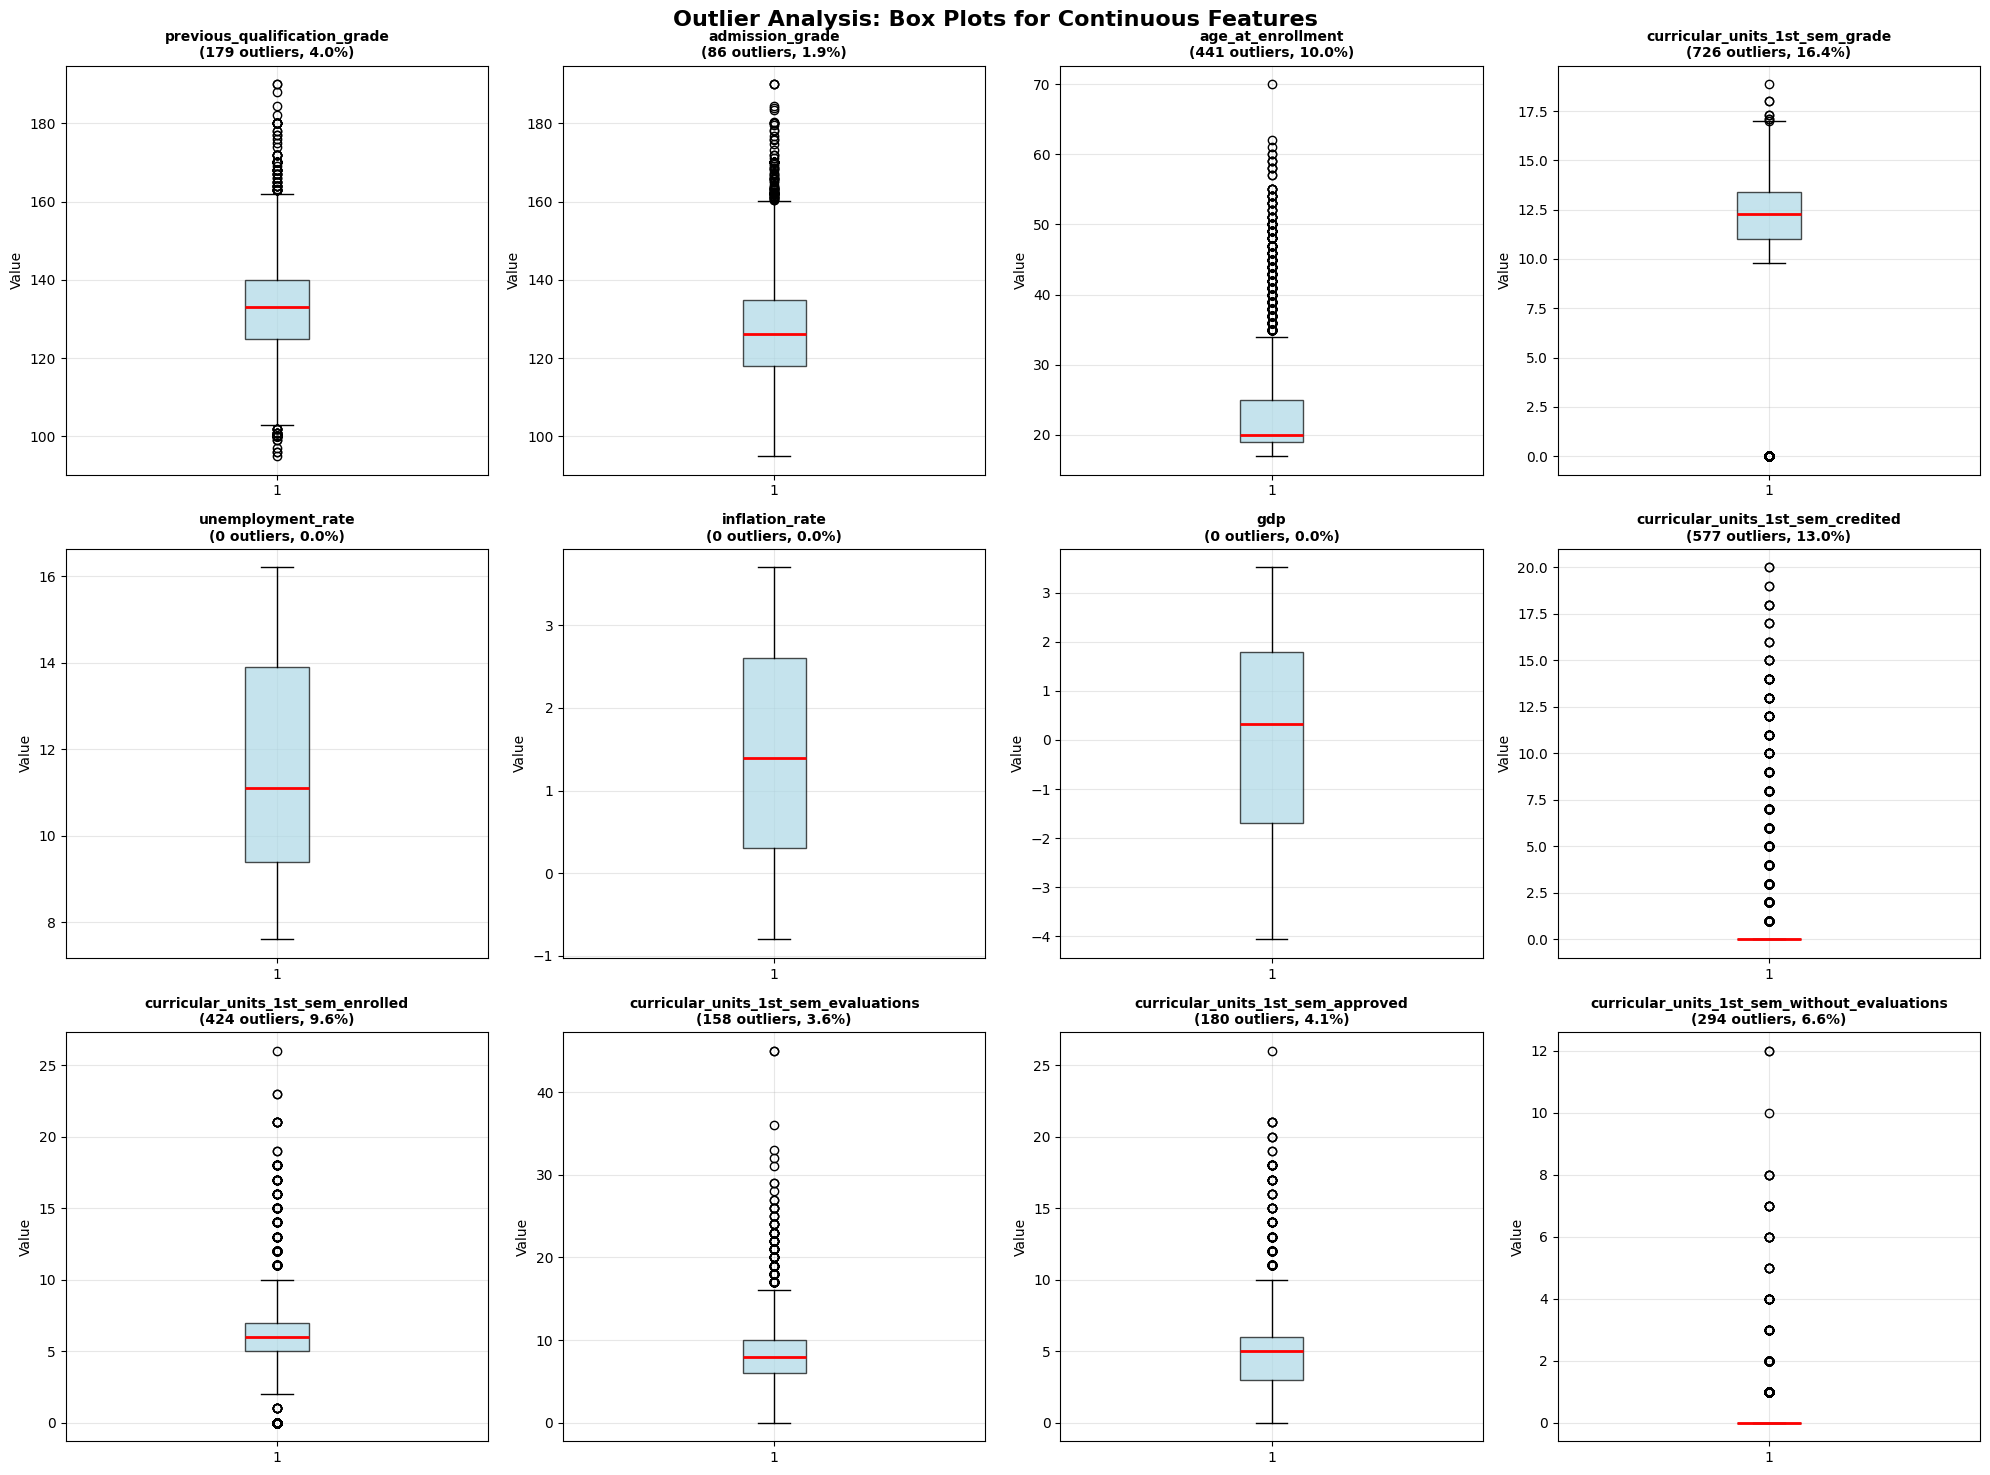

OUTLIER ANALYSIS SUMMARY

Total features analysed: 12

Features with >10% outliers: 2

Features with >5% outliers: 5

Top features by outlier percentage:

Feature  Outlier_Count  \
3                 curricular_units_1st_sem_grade            726   
7              curricular_units_1st_sem_credited            577   
2                              age_at_enrollment            441   
8              curricular_units_1st_sem_enrolled            424   
11  curricular_units_1st_sem_without_evaluations            294   

    Outlier_Percentage  
3                 16.4  
7                 13.0  
2                 10.0  
8                  9.6  
11                 6.6

In [21]:
# Outlier analysis using box plots and IQR method
def plot_outlier_analysis(df, continuous_features, figsize=(20, 15)):
    n_features = len(continuous_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Outlier Analysis: Box Plots for Continuous Features', 
                 fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    outlier_summary = {}
    
    for i, feature in enumerate(continuous_features):
        ax = axes[i]
        
        # Create box plot
        ax.boxplot(df[feature].dropna(), 
                  patch_artist=True, 
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
        
        # Calculate outliers using IQR method
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        outlier_summary[feature] = {
            'count': outlier_count,
            'percentage': outlier_percentage
        }
        
        ax.set_title(f'{feature}\n({outlier_count} outliers, {outlier_percentage:.1f}%)', 
                    fontsize=10, fontweight='bold')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("OUTLIER ANALYSIS SUMMARY")
    print(f"Total features analysed: {len(continuous_features)}")
    
    outlier_df = pd.DataFrame([
        {'Feature': k, 'Outlier_Count': v['count'], 'Outlier_Percentage': round(v['percentage'], 1)}
        for k, v in outlier_summary.items()
    ]).sort_values('Outlier_Percentage', ascending=False)
    
    print(f"Features with >10% outliers: {len(outlier_df[outlier_df['Outlier_Percentage'] > 10])}")
    print(f"Features with >5% outliers: {len(outlier_df[outlier_df['Outlier_Percentage'] > 5])}")
    print("\nTop features by outlier percentage:")
    print(outlier_df.head())

    
    return outlier_df

outlier_results = plot_outlier_analysis(df, continuous_features)

In [22]:
# Verify data leakage from second semester features
def verify_leakage_claims(df):
    df = df.copy()
    
    # Check for required columns
    required_cols = ['target', 'curricular_units_2nd_sem_grade']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f'⚠️  Cannot verify leakage - missing columns: {missing_cols}')
        return
    
    # Extract dropout and continuing students
    dropout_students = df[df['target'] == 'Dropout']
    continuing_students = df[df['target'].isin(['Graduate', 'Enrolled'])]
    
    # Check percentage of dropout students with zero 2nd semester grades
    dropout_zeros = (dropout_students['curricular_units_2nd_sem_grade'] == 0).sum()
    dropout_total = len(dropout_students)
    dropout_zero_pct = (dropout_zeros / dropout_total) * 100
    
    print(f'Dropout students with zero 2nd semester grades: {dropout_zeros}/{dropout_total} ({dropout_zero_pct:.1f}%)')
    
    # Test simple prediction rule accuracy
    df_temp = df.copy()
    df_temp['predicted_dropout'] = (df_temp['curricular_units_2nd_sem_grade'] == 0).astype(int)
    df_temp['actual_dropout'] = (df_temp['target'] == 'Dropout').astype(int)
    
    accuracy = (df_temp['predicted_dropout'] == df_temp['actual_dropout']).mean()
    accuracy_pct = accuracy * 100
    
    print(f'Prediction rule accuracy: {accuracy:.3f} ({accuracy_pct:.1f}%)')
    
    # Additional context
    continuing_zeros = (continuing_students['curricular_units_2nd_sem_grade'] == 0).sum()
    continuing_total = len(continuing_students)
    continuing_zero_pct = (continuing_zeros / continuing_total) * 100
    
    print(f'Continuing students with zero 2nd semester grades: {continuing_zeros}/{continuing_total} ({continuing_zero_pct:.1f}%)')
    print(f'Difference: {dropout_zero_pct:.1f}% - {continuing_zero_pct:.1f}% = {dropout_zero_pct - continuing_zero_pct:.1f}% gap')
    print('✅ Confirms significant leakage pattern - justifies exclusion')

# Run verification on dataset with second semester features
verify_leakage_claims(df_with_sem2)

Dropout students with zero 2nd semester grades: 727/1421 (51.2%)

Prediction rule accuracy: 0.811 (81.1%)

Continuing students with zero 2nd semester grades: 143/3003 (4.8%)

Difference: 51.2% - 4.8% = 46.4% gap

✅ Confirms significant leakage pattern - justifies exclusion

In [23]:
# EDA Summary 
print('📋 EXPLORATORY DATA ANALYSIS SUMMARY')
print('='*50)

# Basic dataset info (assuming df is loaded)
print(f'\n🗂️  DATASET OVERVIEW:')
print(f'   • {df.shape[0]:,} students, {df.shape[1]:,} features')
print(f'   • No missing values, no duplicates')

# Target distribution (if target_binary exists)
if 'target_binary' in df.columns:
    withdrawals = df['target_binary'].sum()
    total = len(df)
    withdrawal_rate = withdrawals / total
    print(f'   • Target: {withdrawals:,} withdrawals ({withdrawal_rate:.1%})')

print(f'\n🔧 KEY FINDINGS FROM ANALYSIS:')

# Use the stored removed features count instead of scanning current df
print(f'   • {len(REMOVED_FEATURES)} second semester features removed (prevented data leakage)')

# Use config-based feature classification (already filtered earlier)
print(f'   • {len(categorical_features)} categorical features')
print(f'   • {len(continuous_features)} continuous features')

print(f'\n⚠️  KNOWN ISSUES FROM ANALYSIS:')
print(f'   • Second semester features successfully removed')
print(f'   • High correlation between 1st semester metrics')
print(f'   • Nationality: 97.5% Portuguese (severely imbalanced)')
print(f'   • Parents\' features: 29-46 categories each (high cardinality)')

print(f'\n🎯 KEY PREDICTORS IDENTIFIED:')
print(f'   • Tuition fees up to date (financial)')
print(f'   • 1st semester grades (academic)')
print(f'   • Age at enrollment (demographic)')
print(f'   • Scholarship holder (financial)')
print(f'   • Course and application mode (contextual)')

print(f'\n✅ NEXT STEPS:')
print(f'   • Engineer high cardinality features')
print(f'   • Address multicollinearity in 1st semester metrics')
print(f'   • Apply feature scaling for k-NN')
print(f'   • Prepare features for logistic regression')

print(f'\n🚀 READY FOR MODEL DEVELOPMENT')

📋 EXPLORATORY DATA ANALYSIS SUMMARY

==================================================

🗂️  DATASET OVERVIEW:

• 4,424 students, 32 features

• No missing values, no duplicates

• Target: 1,421 withdrawals (32.1%)

🔧 KEY FINDINGS FROM ANALYSIS:

• 6 second semester features removed (prevented data leakage)

• 18 categorical features

• 12 continuous features

⚠️  KNOWN ISSUES FROM ANALYSIS:

• Second semester features successfully removed

• High correlation between 1st semester metrics

• Nationality: 97.5% Portuguese (severely imbalanced)

• Parents' features: 29-46 categories each (high cardinality)

🎯 KEY PREDICTORS IDENTIFIED:

• Tuition fees up to date (financial)

• 1st semester grades (academic)

• Age at enrollment (demographic)

• Scholarship holder (financial)

• Course and application mode (contextual)

✅ NEXT STEPS:

• Engineer high cardinality features

• Address multicollinearity in 1st semester metrics

• Apply feature scaling for k-NN

• Prepare features for logistic regression

🚀 READY FOR MODEL DEVELOPMENT